## Introduction
<br />
### Experimental Method
<br />
### Theory
    Lagrangian Interpolation
    Synthetic Schlieren
<br />
### Analysis
    Qualitative Schlieren
    Quantitative Schlieren
<br />
### Conclusion


# Introduction


* The technique of synthetic schlieren is used to study the flow of a fluid of variable density. 
* By using a digital camera, a backlit patterened image, and a pattern matching algorithm, such as Lagrangian interpolation, we can measure the distortions in the fluid throughout time.
    <img src="distortedpatterns.png">

* The specific algorithm that we used first came from Sutherland, Dalziel, et.al. in a paper on internal waves in 1999.
* However, our first transcription was slow and produced noisy results. 
* In an effort to improve upon this, we made alterations to our algorithm that reduced its time down to a fraction of a second for a 700 frame video. 
* We also managed to reduce the noise in the output by performing a running mean average of the polynomials we interpolated.

# Experimental Method

Set up includes grayscale digital video recorder, flat screen television with pattern displayed, wave tank, and wave maker.

<img src="synschlieren.jpg">

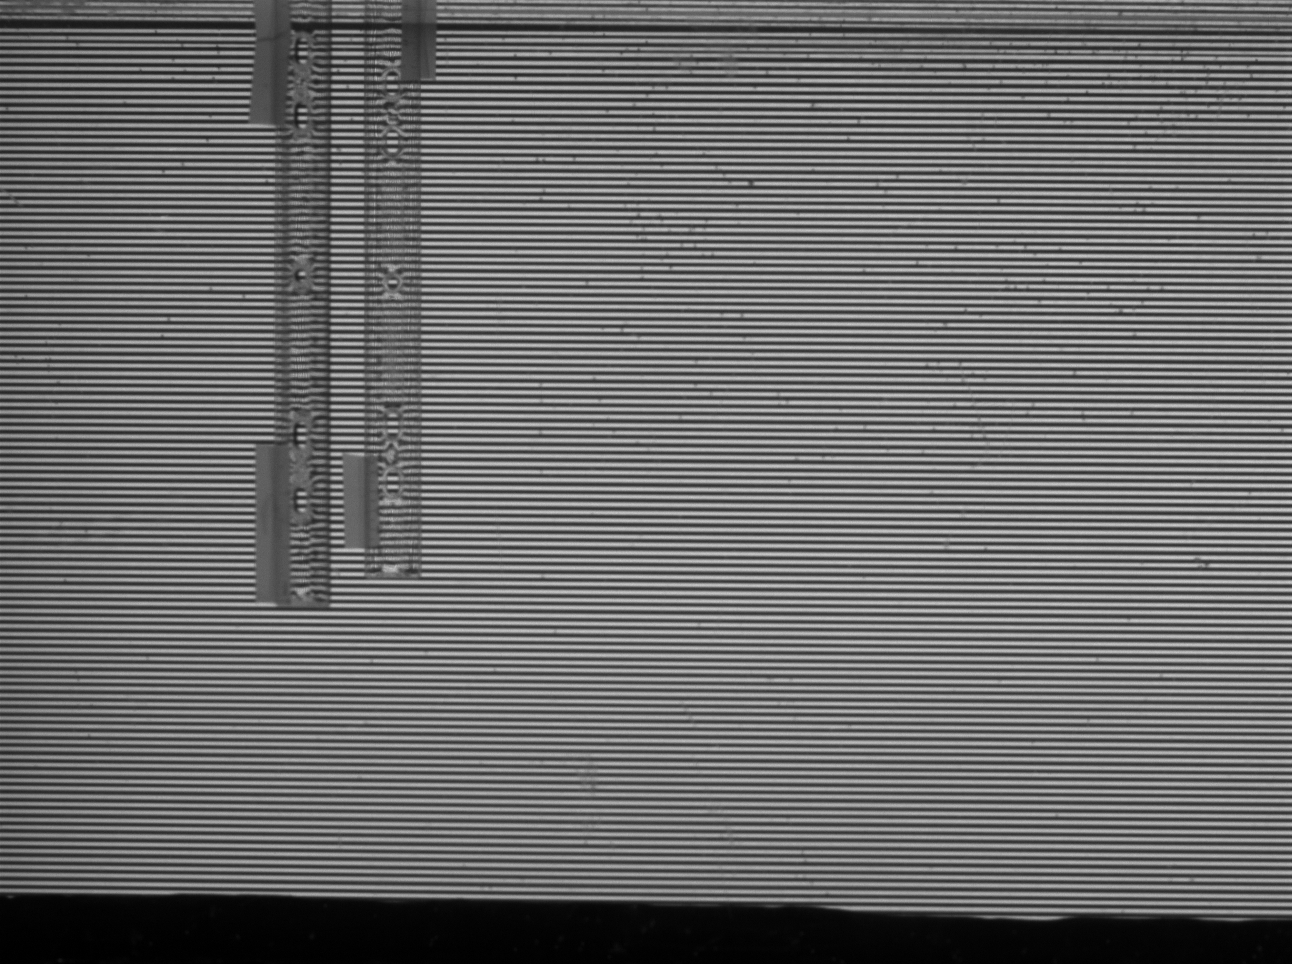

In [123]:
filename = "/home/evankielley/research/wavetank/dv_20161014154210/1.jpg"
Image(filename, width=600)

In [126]:
im1 = io.imread(frames[0])
im1 = im1.astype(np.float32)
im2 = io.imread(frames[750])
frames[0]
im1

array([[  60.,   60.,   58., ...,  124.,  119.,  117.],
       [  97.,   94.,   90., ...,  149.,  144.,  140.],
       [ 126.,  126.,  118., ...,  139.,  138.,  141.],
       ..., 
       [   0.,    1.,    1., ...,    3.,    1.,    5.],
       [   2.,    1.,    2., ...,    4.,    5.,    3.],
       [   1.,    0.,    0., ...,    3.,    4.,    4.]], dtype=float32)

# Theory

## Lagrangian Interpolation

Lagrangian interpolation works by fitting a unique polynomial $y(x)$ to $N + 1$ known samples, $f(x_k)$, where $k=0,1,2,\ldots,N$.

\begin{equation}
l_k(x) = \frac{(x - x_0) \cdots (x - x_{k-1}) (x - x_{k+1}) \cdots (x - x_N)}{(x_k - x_0) \cdots (x_k - x_{k-1}) (x_k - x_{k+1}) \cdots (x_k - x_N)}.
\end{equation} 

Where $l_k(x)$ is a basis polynomial. 

\begin{equation}
l_k(x_j) =  \delta_{kj} =
    \begin{cases}
            1, &         \text{if } k=j,\\
            0, &         \text{if } k\neq j.
    \end{cases}
\end{equation}

So putting it all together, unique polynomial which fits the set of samples.

\begin{equation}
y(x) = \sum_{k=0}^N l_k(x)f(x_k)
\end{equation}

## Synthetic Schlieren

* Synthetic schlieren is a technique used to visualize the flow of a fluid with variable indices of refraction (Sutherland, 1999). 
* Changes in refractive index cause a distortion in the image recorded by the camera. 
* With the sequence of distorted images, a pattern matching algorithm can quantify the distortions over time and a model for the fluid flow can be made. 

* The pattern matching algorithm we used is based upon Lagrangian quadratic interpolation. which fits a second order polynomial to three given points. 
* In our case, these three points are within one column of pixels in our reference image and are grouped consecutively by row. 
* When we fit a polynomial to these three points, we also consider a point in our test image at the middle row number of the three points used to fit the curve. 
* This allows us to calculate the shift in pattern from one image frame to the next and in turn gives us a value for $\Delta z$ which may then be used to visualize an internal wave as it oscillates through its medium.\\

In mathematical terms, $\Delta z$ can be represented by the following quadratic equation:

\begin{equation}
\Delta z = \frac{(I' - I_0)(I' - I_1)}{(I_{-1} - I_0)(I_{-1} - I_1)} + \frac{(I' - I_0)(I' - I_{-1})}{(I_1 - I_0)(I_1 - I_{-1})}
\end{equation}

where $I_{-1}$, $I_0$, and $I_1$ are short-hand for $I(x_p, z_p - 1)$, $I(x_p, z_p)$, and $I(x_p, z_p + 1)$, respectively; and $I'$ represents the test pixel from the test image.

# Analysis

### Qualitative Synthetic Schlieren

The simplest approach is to subtract a reference image from the current image.

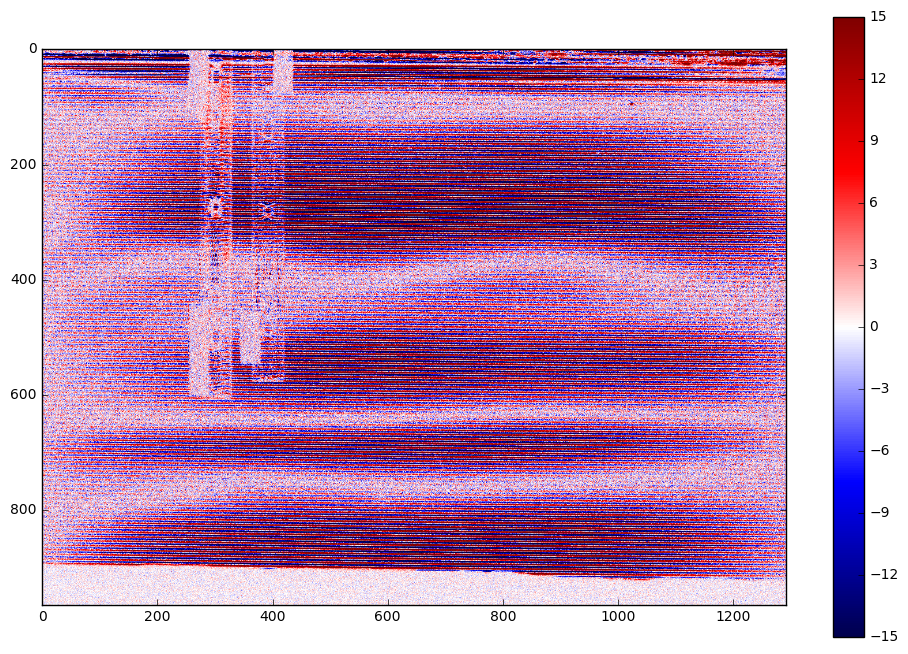

In [137]:
ref_img = io.imread(frames[1000])*1.0
img = io.imread(frames[2005])
diff = img - ref_img
fig = plt.figure(figsize=(12, 8)); ax = fig.add_subplot(111)
m = ax.imshow(diff, cmap=plt.get_cmap('seismic'), clim = [-15, 15])
ax.axis([0, img.shape[1], img.shape[0], 0])
cb = fig.colorbar(m)

In [61]:
def getDelZ(i, j, i0, im1, im2):

    if j == 0:  
    # linear interpolation at bottom boundary 
        deltaZ = (im2[i,0]-im1[i0,0])/(im1[i0,1]-im1[i0,0])
    elif j == 699: 
    # linear interpolation at top boundary 
        deltaZ = (im2[i,-1]-im1[i0,-1])/(im2[i0,-2]-im2[i0,-1])
    else: 
    # quadratic interpolation 
        deltaZ = (im2[i,j]-im1[i0,j])*(im2[i,j]-im1[i0, j+1]) 
        /((im1[i0,j-1]-im1[i0,j])*(im1[i0,j-1]-im1[i0,j+1])) 
        + (im2[i,j]-im1[i0,j])*(im2[i,j]-im1[i0,j-1])
        / ((im1[i0,j+1]-im1[i0,j])*(im1[i0,j+1]-im1[i0,j-1]))
    return deltaZ

[dz0]Elapsed: 3.0343003273010254


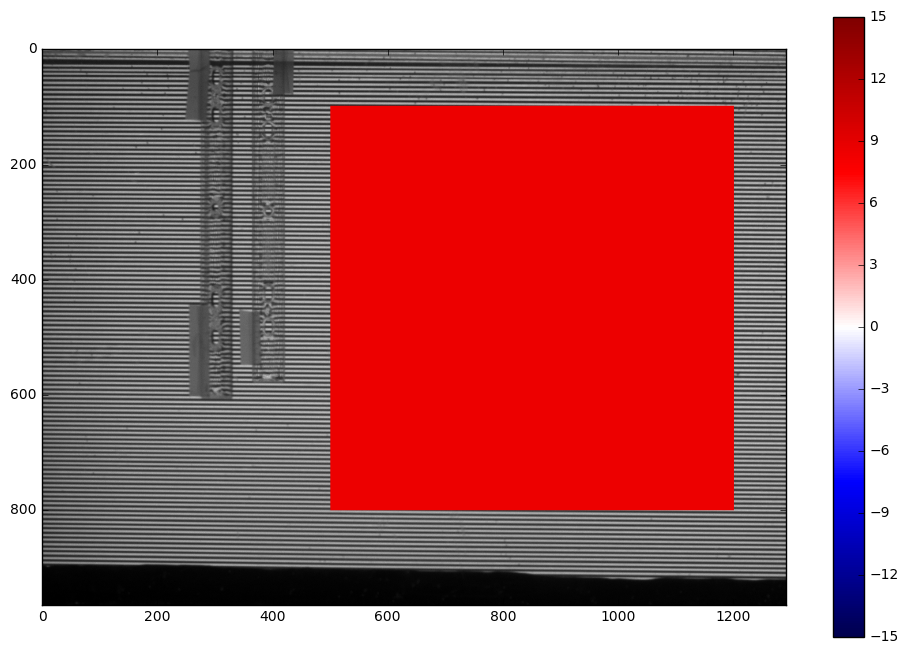

In [62]:
dz0= make_one_frame(0,'dz0')

In [63]:
def compute_dz1(im1, im2):

    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)
    N, M = im1.shape

    ans = np.zeros((700,700))
    
    for j in range(0,700):
        for i in range(1,696):
                
            A = im2[i,j] - im1[i,j]

            B = im2[i,j] - im1[i+1,j]

            C = im2[i+1,j] - im1[i-1,j]

            D = im1[i-1,j] - im1[i+1,j]

            E = im1[i-2,j] - im1[i+2,j]

            F = im1[i+1,j] - im1[i-1,j]

            temp = (- A/E * (B/D + C/F))

            ans[i,j] = temp
             
    return ans       

[dz1]Elapsed: 1.9318690299987793


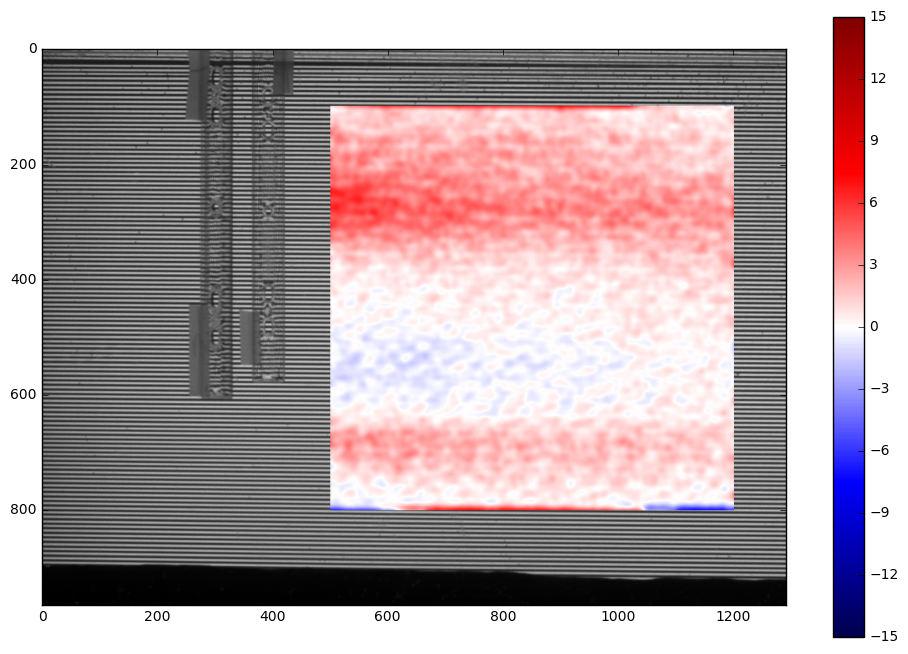

In [64]:
dz1= make_one_frame(0,'dz1')

In [65]:
def compute_dz2(im1, im2):
    
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)
    N, M = im1.shape
    zerorow = np.zeros(M)

    A = im2[:,:] - im1[:,:]

    B = im2[:-1,:] - im1[1:,:]
    B = np.vstack((B, zerorow))

    C = im2[1:,:] - im1[:-1,:]
    C = np.vstack((zerorow, C))

    D = im1[:-1,:] - im1[1:,:]
    D = np.vstack((zerorow, D))

    E = im1[:-2,:] - im1[2:,:]
    E = np.vstack((zerorow, E, zerorow))

    F = im1[1:,:] - im1[:-1,:]
    F = np.vstack((F, zerorow))

    ans = - A/E * (B/D + C/F)
    
    return ans

[dz2]Elapsed: 0.33554506301879883


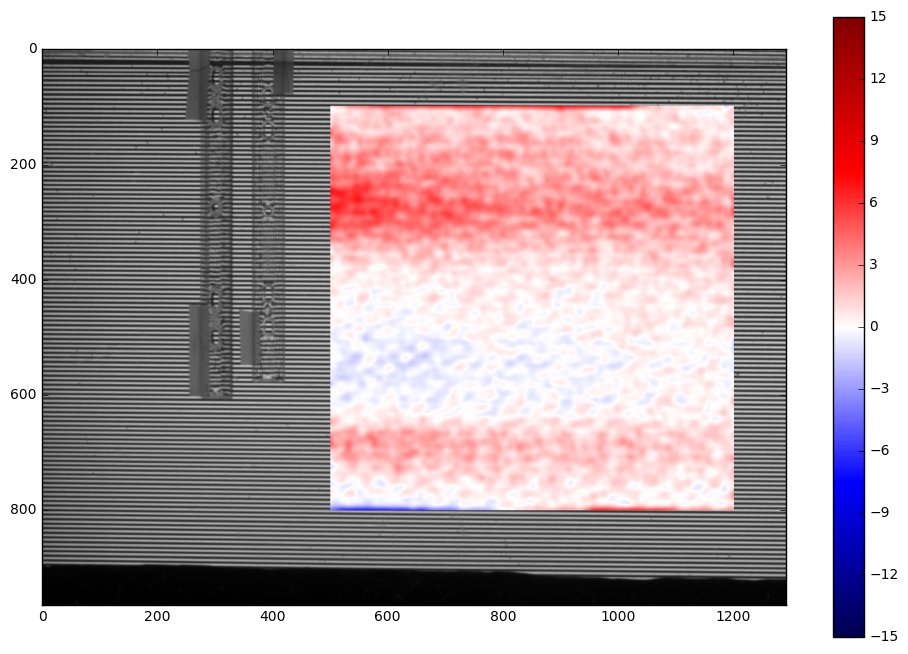

In [66]:
dz2= make_one_frame(0,'dz2')

In [67]:
def compute_dz3(im1, im2):
    
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)
    N, M = im1.shape
    zerorow = np.zeros(M)

    A = im2[:,:] - im1[:,:]

    B = im2[:-1,:] - im1[1:,:]
    B = np.vstack((B, zerorow))

    C = im2[1:,:] - im1[:-1,:]
    C = np.vstack((zerorow, C))

    D = im1[:-1,:] - im1[1:,:]
    D = np.vstack((zerorow, D))

    E = im1[:-2,:] - im1[2:,:]
    E = np.vstack((zerorow, E, zerorow))

    F = im1[1:,:] - im1[:-1,:]
    F = np.vstack((F, zerorow))

    ans = - A/E * (B/D + C/F)  
    UP = np.vstack((zerorow, ans[1:,:]))
    DOWN = np.vstack((ans[:-1,:], zerorow))  
    ans = (UP + ans + DOWN)/3
    
    return ans

[dz3]Elapsed: 0.34465765953063965


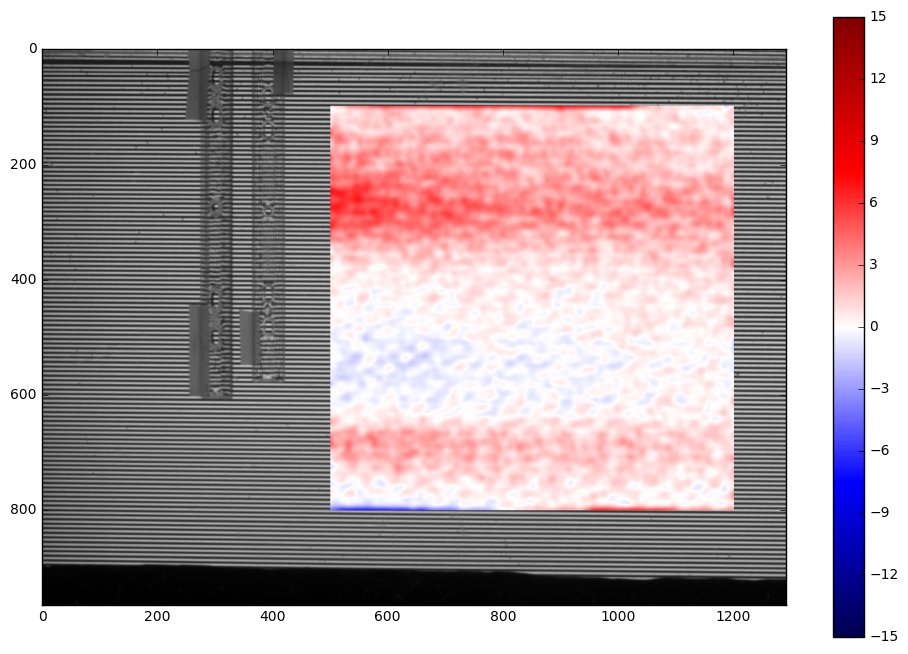

In [68]:
dz3= make_one_frame(0,'dz3')

In [71]:
f_old = np.fft.fft2(dz1, norm='ortho')
fshift_old = np.fft.fftshift(f_old)
magnitude_spectrum_old = 20*np.log(np.abs(fshift_old))

freq = np.fft.fftfreq( 700, 0.05 )
freq = np.fft.fftshift(freq)

f_new = np.fft.fft2(dz2, norm='ortho')
fshift_new = np.fft.fftshift(f_new)
magnitude_spectrum_new = 20*np.log(np.abs(fshift_new))

ms_diff = 20*np.log(np.abs(fshift_new - fshift_old))

ms_diff = magnitude_spectrum_old - magnitude_spectrum_new

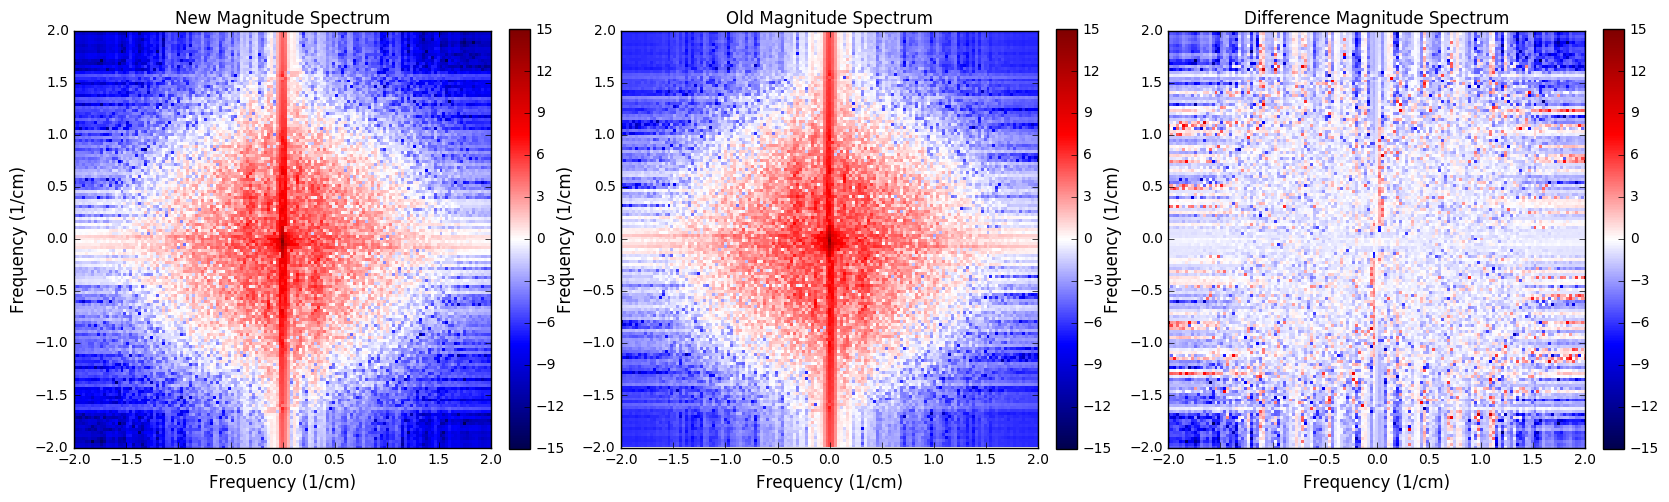

In [73]:
plt.subplot(131),
plt.imshow(magnitude_spectrum_old, cmap = 'seismic',interpolation='nearest', extent=[freq[0],freq[-1],freq[0],freq[-1]])
plt.xlim(-2,2); plt.ylim(-2,2); plt.title('New Magnitude Spectrum'); plt.xlabel('Frequency (1/cm)', fontsize=12); plt.ylabel('Frequency (1/cm)', fontsize=12)
cb = plt.colorbar(m,fraction=0.046, pad=0.04)

plt.subplot(132),
plt.imshow(magnitude_spectrum_new, cmap = 'seismic',interpolation='nearest', extent=[freq[0],freq[-1],freq[0],freq[-1]])
plt.xlim(-2,2); plt.ylim(-2,2); plt.title('Old Magnitude Spectrum'); plt.xlabel('Frequency (1/cm)', fontsize=12); plt.ylabel('Frequency (1/cm)', fontsize=12)
cb = plt.colorbar(m,fraction=0.046, pad=0.04)

plt.subplot(133),plt.imshow(ms_diff, cmap = 'seismic',interpolation='nearest', extent=[freq[0],freq[-1],freq[0],freq[-1]])
plt.xlim(-2,2); plt.ylim(-2,2); plt.title('Difference Magnitude Spectrum'); plt.xlabel('Frequency (1/cm)', fontsize=12); plt.ylabel('Frequency (1/cm)', fontsize=12)
cb = plt.colorbar(m,fraction=0.046, pad=0.04)

# Future Work

We accomplished less work than we intended to on this algorithm so much future work remains. We'd also like to try:
* Fitting larger polynomials and comparing them to more pixel points.
* Performing the same algorithm but with the test image being more than one frame away.
* Try other pattern fitting algorithms.